# DATA 512 Assignment 2: Bias in data
This notebook identifies potential sources of bias in the Wikipedia Talk corpus and describes some of their implications.

## Step 0: Background research & gathering the data

### Background research 

- Overview of the research project: https://meta.wikimedia.org/wiki/Research:Detox 
- Dataset description and schemas: https://meta.wikimedia.org/wiki/Research:Detox/Data_Release 
- Overview of Google’s Conversation AI project: https://conversationai.github.io/ 

### Gathering the data
Get the personal attacks and toxicity datasets for the annotated comments and the annotations. Additionally, get the demographics data for the persoanl attack data. These will be the datasets used in Step 1 for analyses. 

Define the urls for each dataset and use the urlretrieve function from the urllib library to download the data.

In [80]:
from urllib.request import urlretrieve

#data urls
ATTACK_ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ATTACK_ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637'
ATTACK_DEMOGRAPHICS_URL = 'https://ndownloader.figshare.com/files/7640752'
TOXICITY_ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7394542' 
TOXICITY_ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7394539'

#download files given the url and file name
urlretrieve(ATTACK_ANNOTATED_COMMENTS_URL, 'data/attack_annotated_comments.tsv')
urlretrieve(ATTACK_ANNOTATIONS_URL, 'data/attack_annotations.tsv')   
urlretrieve(ATTACK_DEMOGRAPHICS_URL, 'data/attack_worker_demographics.tsv')   
urlretrieve(TOXICITY_ANNOTATED_COMMENTS_URL, 'data/toxicity_annotated_comments.tsv')
urlretrieve(TOXICITY_ANNOTATIONS_URL, 'data/toxicity_annotations.tsv') 

('data/toxicity_annotations.tsv', <http.client.HTTPMessage at 0x1d01ce3d128>)

Read in the downloaded data files into dataframes for analysis. View the first 5 lines of the toxicity annotations dataframe.

In [60]:
import pandas as pd

attack_comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t')
attack_annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')
attack_demographics = pd.read_csv('attack_worker_demographics.tsv',  sep = '\t')
toxicity_comments = pd.read_csv('toxicity_annotated_comments.tsv', sep = '\t')
toxicity_annotations = pd.read_csv('toxicity_annotations.tsv',  sep = '\t')

toxicity_annotations.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


## Step 1: Select and perform analysis
There are two analyses performed in this section.

The first analyzes the toxicity dataset. There is a demographic dataset provided which enables the ability to see how different demographics could potentially bias the data. The research question for this analysis is: 
- How do demographics play a role in how people perceived whether a comment was an attack or not?

The second is a comparative analysis across the toxicity dataset and the personal attacks dataset. Some types of hostile comments may be more agreeable or disagreeable than others which could impact the reliability of the models trained on these datasets. The research question is: 
- Is there a significant difference in the level of agreement in how workers label comments as personal attacks vs toxic comments? 

### Analysis 1: Worker demographics impacting labelling

How do demographics play a role in how people perceived a comment as being an attack or not?

The demographics included in the personal attack worker demographics data are gender, whether english is the worker's first language, their age group, and education. 

The demographic makeup of the labellers could bias how each person decides whether to label a comment the way they do. This analysis will use the personal attack dataset as an example. 

The cell below plots the distribution of labellers by each demographic. 

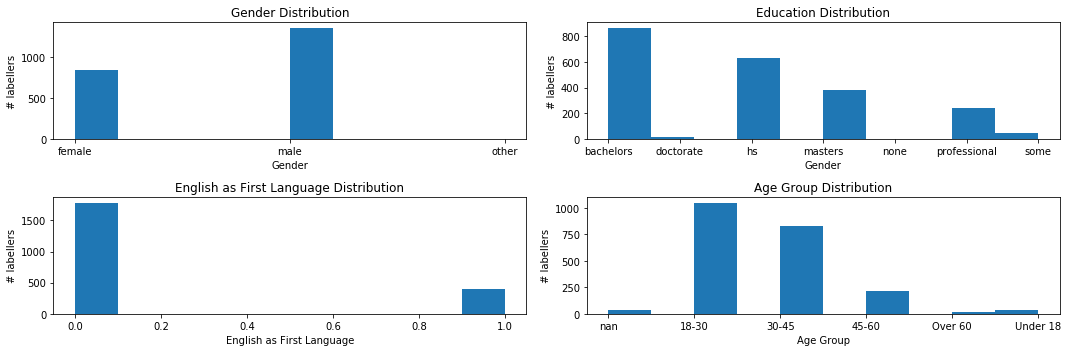

In [99]:
import matplotlib.pyplot as plt 
def set_plot(demographic, i, j, title, x_label):
    axes[i][j].hist(attack_demographics[demographic])
    axes[i][j].set_title(title)
    axes[i][j].set_xlabel(x_label)
    axes[i][j].set_ylabel("# labellers")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
set_plot("gender", 0, 0, "Gender Distribution", "Gender")
set_plot("education", 0, 1, "Education Distribution", "Gender")
set_plot("english_first_language", 1, 0, "English as First Language Distribution", "English as First Language")
set_plot("age_group", 1, 1, "Age Group Distribution", "Age Group")
plt.savefig("images/PersonalAttackDemographicsDistributions.png")
fig.tight_layout()

From the distributions we can see the most of the labellers are male, do not speak English as a first language, completed high school or have a bachelors degree, and are between the ages of 18 - 45.

The percent breakdown and counts are as follows.

In [77]:
def count_and_percent(col):
    print("-------------")
    print(col, "percent breakdown:")
    print(attack_demographics[col].value_counts(normalize=True), "\n")
    print(col, "breakdown by count:")
    print(attack_demographics[col].value_counts(), "\n")

count_and_percent("gender")
count_and_percent("english_first_language")
count_and_percent("age_group")
count_and_percent("education")

-------------
gender percent breakdown:
male      0.615982
female    0.383562
other     0.000457
Name: gender, dtype: float64 

gender breakdown by count:
male      1349
female     840
other        1
Name: gender, dtype: int64 

-------------
english_first_language percent breakdown:
0    0.816438
1    0.183562
Name: english_first_language, dtype: float64 

english_first_language breakdown by count:
0    1788
1     402
Name: english_first_language, dtype: int64 

-------------
age_group percent breakdown:
18-30       0.486775
30-45       0.385615
45-60       0.101160
Under 18    0.017169
Over 60     0.009281
Name: age_group, dtype: float64 

age_group breakdown by count:
18-30       1049
30-45        831
45-60        218
Under 18      37
Over 60       20
Name: age_group, dtype: int64 

-------------
education percent breakdown:
bachelors       0.393607
hs              0.288128
masters         0.175799
professional    0.110959
some            0.021918
doctorate       0.009132
none      

In [ ]:
Looking at the results from the histograms and stats...

- Over 80% of labellers said that English was not their first language; however, the comments being analyzed are exclusively in English. This can bias the labelling depending on the level of proficiency in English and familiarity of aspects like common cultural references, idioms, and slang. 

- For gender, 62% of the labellers were male, 38% were women, and 1 person who identified as other. Having less than 1% of the labelers identifying as other biases the data because according to the LGBTQ+ Population Quick Facts in 2017 about 4.5% of US adults identified as LGBT and 8.2% of millenials identified as LGBT (source: https://diversity.iupui.edu/offices/lgbtq/images/LGBT-Population-Quick-Facts.pdf). Additionally, men and women make up roughly the same percent of the population in the real world. It would be better to have a more representative percentage of labelers who identify as other and women. 

- Similarly, the age group and education proportions do not represent the population as a whole. This can influence the way workers label the data because people have different experiences and perspectives across generations and levels of education. 

Next, probabilities will be calculated to see how demographics play a role in labelling. To do this, the cell below first joins the demographics dataset for attacks with the annotations dataset to get the annotations per worker. 

In [78]:
attack_demo_ann = pd.merge(attack_annotations, attack_demographics, 
how='inner', on='worker_id')
attack_demo_ann.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack,gender,english_first_language,age_group,education
0,37675,1362,0.0,0.0,0.0,0.0,0.0,male,0,18-30,masters
1,3202092,1362,0.0,0.0,0.0,0.0,0.0,male,0,18-30,masters
2,4745553,1362,0.0,0.0,0.0,0.0,0.0,male,0,18-30,masters
3,4855563,1362,0.0,0.0,0.0,0.0,0.0,male,0,18-30,masters
4,8350378,1362,0.0,0.0,0.0,0.0,0.0,male,0,18-30,masters


Second, get the probabilities for all the demographics that make up more than 3% of the data:
- P(Attack=True | Female)
- P(Attack=True | Male)
- P(Attack=True | English is first language)
- P(Attack=True | English is not first language)
- P(Attack=True | Age group is 18 - 30)
- P(Attack=True | Age group is 30 - 45)
- P(Attack=True | Age group is 45 - 60)
- P(Attack=True | Education is high school)
- P(Attack=True | Education is bachelors)
- P(Attack=True | Education is masters)
- P(Attack=True | Education is professional)

As you can see below, labelers who identified as female were ~1.5% more likely to label a comment as a personal attack than labelers who identified as male. This is not much of a difference. 

In [239]:
print("P(Attack=True | Female):\n", attack_demo_ann[attack_demo_ann["gender"] == "female"]["attack"].value_counts(normalize=True))
print("\nP(Attack=True | Male):\n", attack_demo_ann[attack_demo_ann["gender"] == "male"]["attack"].value_counts(normalize=True))

P(Attack=True | Female):
 0.0    0.826402
1.0    0.173598
Name: attack, dtype: float64

P(Attack=True | Male):
 0.0    0.841309
1.0    0.158691
Name: attack, dtype: float64

P(Attack=True | Other):
 0.0    0.554217
1.0    0.445783
Name: attack, dtype: float64


As you can see below, labelers who said they spoke English as their first language were ~2% more likely to label comments as a personal attack than labelers who said English was not their first language. 

In [55]:
print("P(Attack=True | English is first language):\n", attack_demo_ann[attack_demo_ann["english_first_language"] == 1]["attack"].value_counts(normalize=True))
print("\nP(Attack=True | English is not first language):\n", attack_demo_ann[attack_demo_ann["english_first_language"] == 0]["attack"].value_counts(normalize=True))

P(Attack=True | English is first language):
 0.0    0.818531
1.0    0.181469
Name: attack, dtype: float64

P(Attack=True | English is not first language):
 0.0    0.838578
1.0    0.161422
Name: attack, dtype: float64


As you can see below, age has a larger effect on whether a labeler marks a comment as a personal attack or not. The older age group of 45-60 was ~5.7% more likely to label comments as an attack compared to labelers in the 18-30 age group and ~3.8% more likely than the 30-45 age group. 

In [57]:
print("P(Attack=True | Age group is 18 - 30):\n", attack_demo_ann[attack_demo_ann["age_group"] == "18-30"]["attack"].value_counts(normalize=True))
print("\nP(Attack=True | Age group is 30 - 45):\n", attack_demo_ann[attack_demo_ann["age_group"] == "30-45"]["attack"].value_counts(normalize=True))
print("\nP(Attack=True | Age group is 45 - 60):\n", attack_demo_ann[attack_demo_ann["age_group"] == "45-60"]["attack"].value_counts(normalize=True))

P(Attack=True | Age group is 18 - 30):
 0.0    0.848967
1.0    0.151033
Name: attack, dtype: float64

P(Attack=True | Age group is 30 - 45):
 0.0    0.829853
1.0    0.170147
Name: attack, dtype: float64

P(Attack=True | Age group is 45 - 60):
 0.0    0.791523
1.0    0.208477
Name: attack, dtype: float64


As you can see below, education has the smallest impact on whether a labeler marked a comment as an attack. Each education group was within half a percentage point of each other. 

In [58]:
print("P(Attack=True | Education is high school):\n", attack_demo_ann[attack_demo_ann["education"] == "hs"]["attack"].value_counts(normalize=True))
print("\nP(Attack=True | Education is bachelors):\n", attack_demo_ann[attack_demo_ann["education"] == "bachelors"]["attack"].value_counts(normalize=True))
print("\nP(Attack=True | Education is masters):\n", attack_demo_ann[attack_demo_ann["education"] == "masters"]["attack"].value_counts(normalize=True))
print("\nP(Attack=True | Education is professional):\n", attack_demo_ann[attack_demo_ann["education"] == "professional"]["attack"].value_counts(normalize=True))

P(Attack=True | Education is high school):
 0.0    0.838819
1.0    0.161181
Name: attack, dtype: float64

P(Attack=True | Education is bachelors):
 0.0    0.834606
1.0    0.165394
Name: attack, dtype: float64

P(Attack=True | Education is masters):
 0.0    0.834386
1.0    0.165614
Name: attack, dtype: float64

P(Attack=True | Education is professional):
 0.0    0.832173
1.0    0.167827
Name: attack, dtype: float64


After looking at the probabilities it appears that age is the demographic with the largest influence in a labelers decision with a difference of ~5.7% between the 18-30 and 45-60 age groups followed by english as a first language, gender, and then education last with less than half a percent of variation between education levels.

Supplementing the probabilities, a logistic regression model will show which demographics effected labelling most.

The cell below sets the y labels as whether or not a comment was considered an attack in addition to creating a dataframe of predictor features by creating a binary feature for each demographic.

In [79]:
y_train = attack_demo_ann["attack"]

X_train = pd.DataFrame(columns=[])

X_train["Age_Under18"] = attack_demo_ann["age_group"].apply(lambda g: 1 if g == "Under 18" else 0)
X_train["Age_18-30"] = attack_demo_ann["age_group"].apply(lambda g: 1 if g == "18-30" else 0)
X_train["Age_30-45"] = attack_demo_ann["age_group"].apply(lambda g: 1 if g == "30-45" else 0)
X_train["Age_45-60"] = attack_demo_ann["age_group"].apply(lambda g: 1 if g == "45-60" else 0)
X_train["Age_Over60"] = attack_demo_ann["age_group"].apply(lambda g: 1 if g == "Over 60" else 0)

X_train["GenderOther"] = attack_demo_ann["gender"].apply(lambda g: 1 if g == "other" else 0)
X_train["GenderFemale"] = attack_demo_ann["gender"].apply(lambda g: 1 if g == "female" else 0)
X_train["GenderMale"] = attack_demo_ann["gender"].apply(lambda g: 1 if g == "male" else 0)

X_train["EnglishFirst"] = attack_demo_ann["english_first_language"]

X_train["Education_HS"] = attack_demo_ann["education"].apply(lambda g: 1 if g == "hs" else 0)
X_train["Education_Bachelors"] = attack_demo_ann["education"].apply(lambda g: 1 if g == "bachelors" else 0)
X_train["Education_Masters"] = attack_demo_ann["education"].apply(lambda g: 1 if g == "masters" else 0)
X_train["Education_Professional"] = attack_demo_ann["education"].apply(lambda g: 1 if g == "professional" else 0)
X_train["Education_Some"] = attack_demo_ann["education"].apply(lambda g: 1 if g == "some" else 0)
X_train["Education_Doctorate"] = attack_demo_ann["education"].apply(lambda g: 1 if g == "doctorate" else 0)
X_train["Education_None"] = attack_demo_ann["education"].apply(lambda g: 1 if g == "none" else 0)

X_train.head()

,Age_Under18,Age_18-30,Age_30-45,Age_45-60,Age_Over60,GenderOther,GenderFemale,GenderMale,EnglishFirst,Education_HS,Education_Bachelors,Education_Masters,Education_Professional,Education_Some,Education_Doctorate,Education_None
0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0


Next up is creating a logistic regression model and fitting it to the data. Below we can see the features and their coefficients from the model.

In [7]:
import statsmodels.api as sm

model = sm.Logit(y_train, X_train)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.444978
         Iterations 7


&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 attack   No. Observations:               855514
Model:                          Logit   Df Residuals:                   855499
Method:                           MLE   Df Model:                           14
Date:                Thu, 15 Oct 2020   Pseudo R-squ.:                0.003154
Time:                        14:06:18   Log-Likelihood:            -3.8068e+05
converged:                       True   LL-Null:                   -3.8189e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P&gt;|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Age_Under18               -0.2978      0.042     -7.174      0.000      -0.379      -0.216
Age_18-30                  0.0069      0.026      0.262      0.793      -0.045       0.059
Age_30-45                  0.1469      0.026      5.579      0.000       0.095       0.199
Age_45-60                  0.3836      0.027     13.991      0.000       0.330       0.437
Age_Over60                 0.2748      0.039      7.090      0.000       0.199       0.351
GenderOther                0.0248        nan        nan        nan         nan         nan
GenderFemale              -1.4276        nan        nan        nan         nan         nan
GenderMale                -1.5177        nan        nan        nan         nan         nan
EnglishFirst               0.1005      0.008     11.924      0.000       0.084       0.117
Education_HS              -0.2793        nan        nan        nan         nan         nan
Education_Bachelors       -0.2494        nan        nan        nan         nan         nan
Education_Masters         -0.2611        nan        nan        nan         nan         nan
Education_Professional    -0.2282        nan        nan        nan         nan         nan
Education_Some            -0.4118        nan        nan        nan         nan         nan
Education_Doctorate       -0.3046        nan        nan        nan         nan         nan
Education_None            -1.1861        nan        nan        nan         nan         nan
==========================================================================================
&quot;&quot;&quot;

Calculating the odds from the log odds (coefficients), we see the features with odds > 1 increase the odds of a comment being labeled as an attack. Odds < 1 shows demographics that increase the odds a comment is not labeled as an attack. 

The results of the cell below show the increase for the following demographics.

- Age_18-30                 0.7%
- Age_30-45                 15.8%
- Age_45-60                 46.8%
- Age_Over60                31.6%
- GenderOther               2.5%
- EnglishFirst              10.6%

In [12]:
import numpy as np
np.exp(result.params) #get the odds

Age_Under18               0.742461
Age_18-30                 1.006927
Age_30-45                 1.158234
Age_45-60                 1.467557
Age_Over60                1.316219
GenderOther               1.025093
GenderFemale              0.239885
GenderMale                0.219211
EnglishFirst              1.105735
Education_HS              0.756290
Education_Bachelors       0.779260
Education_Masters         0.770216
Education_Professional    0.795967
Education_Some            0.662451
Education_Doctorate       0.737382
Education_None            0.305423
dtype: float64

This analysis shows there is misrepresentation in the personal attack dataset, especially around gender identity, age, and English as a second language. Additionally, the analysis shows that these demographics have a correlational affect on how workers labelled the comments. Therefore, at the minimum an appropriate correctional weight should be applied when using this data to reduce bias. To reduce bias related to demographics a more representative group of labellers should be used and additional demographic data should be included such as ethnicity, household income, and state.

### Analysis 2: Labelling agreement for personal attacks vs toxicity 
 
Is there a significant difference in agreement for how workers label comments as personal attacks vs toxic comments? 

Labellers could have different ideas of what constitutes an attack or toxic comment. The shared definition with several examples helps to minimize this bias. This analysis will look into how much the shared definition and "practice problems" helped with consistent labelling. This analysis will compare the disagreement for the attack dataset to the toxicity dataset. 

To measure the disagreement between labellers for the toxicity and attack datasets, the cell below first gets the number of workers who labeled each comment as toxic/attack or not toxic/not attack. The rev_id is the revision id of the edit that added the comment so each rev_id is a comment. 

In [81]:
def get_num_labels_per_option(df, col):
    num_labels_per_option = df.groupby('rev_id')[col].value_counts() #options to label are either 1=Yes/toxic or 0=No/not toxic
    num_labels_per_option = pd.DataFrame(num_labels_per_option) #convert into dataframe
    num_labels_per_option.columns = ['NumLabelers'] #rename column
    num_labels_per_option.reset_index(inplace=True)
    return num_labels_per_option

toxic_num_labels_per_option = get_num_labels_per_option(toxicity_annotations, 'toxicity')    
attack_num_labels_per_option = get_num_labels_per_option(attack_annotations, 'attack')
attack_num_labels_per_option.head()

,rev_id,attack,NumLabelers
0,37675,0.0,10
1,44816,0.0,9
2,49851,0.0,10
3,89320,0.0,5
4,89320,1.0,4


Next, for both datasets seperate the workers into two dataframes per comment where one contains the number of workers who labelled the comment as true and the other dataframe contains the number of workers who labelled the comment as false. This will allow the easy calculation of the number of workers who disagreed. 

In [82]:
not_toxic = toxic_num_labels_per_option[toxic_num_labels_per_option["toxicity"] == 0] #only not toxic labels
not_toxic.columns = ["rev_id", "toxicity", "num_workers_labelling_no"]
toxic = toxic_num_labels_per_option[toxic_num_labels_per_option["toxicity"] == 1] #only toxic labels
toxic.columns = ["rev_id", "toxicity", "num_workers_labelling_yes"]

not_attack = attack_num_labels_per_option[attack_num_labels_per_option["attack"] == 0] #only not attack labels
not_attack.columns = ["rev_id", "attack", "num_workers_labelling_no"]
attack = attack_num_labels_per_option[attack_num_labels_per_option["attack"] == 1] #only attack labels
attack.columns = ["rev_id", "attack", "num_workers_labelling_yes"]
attack.head()

,rev_id,attack,num_workers_labelling_yes
4,89320,1.0,4
14,155243,1.0,2
17,192579,1.0,1
21,249432,1.0,2
27,290598,1.0,3


Then join the dataframes on the revision id and get the percent of workers who disagreed from the majority decision. 

In [83]:
def get_disagreement(yes_df, no_df, col):
    disagreement = pd.merge(yes_df, no_df, how='inner', on="rev_id") #inner join on comments 
    disagreement["num_workers_disagree"] = disagreement.apply(lambda s: #get the number of workers who disagreed from the majority decision
        s["num_workers_labelling_no"] if s["num_workers_labelling_yes"] >= s["num_workers_labelling_no"] else s["num_workers_labelling_yes"], axis=1)
    disagreement["total_labellers"] = disagreement["num_workers_labelling_yes"] + disagreement["num_workers_labelling_no"]
    disagreement["percent_disagree"] = disagreement["num_workers_disagree"] / disagreement["total_labellers"]
    disagreement = disagreement.drop([col + "_x", col + "_y"], axis=1)
    return disagreement

toxicity_disagreement = get_disagreement(toxic, not_toxic, "toxicity")
attack_disagreement = get_disagreement(attack, not_attack, "attack")
attack_disagreement.head()

,rev_id,num_workers_labelling_yes,num_workers_labelling_no,num_workers_disagree,total_labellers,percent_disagree
0,89320,4,5,4.0,9,0.444444
1,155243,2,7,2.0,9,0.222222
2,192579,1,7,1.0,8,0.125000
3,249432,2,8,2.0,10,0.200000
4,290598,3,15,3.0,18,0.166667


Now, get the average percent of labellers who disagreed from the majority of the workers for the attack and toxicity datasets. The output below shows the averages are within 1% of eachother which indicates consistency between the datasets in the amount of disagreement. However, since 20% of the labellers disagreed from the majority decision on average, this shows that the shared definition and practice examples were not significantly sufficient for having consistent labelling for each comment. To increase the quality of labelling to reduce disagreement, the following acitivies may help:
- Reminder of the definition every 50 labels 
- More examples before starting

In [19]:
print("Average percent of labeller disagreement per comment:")
print("\t toxicity data: %.3f%%" % (100 * toxicity_disagreement["percent_disagree"].mean()))
print("\t attack data: %.3f%%" % (100 * attack_disagreement["percent_disagree"].mean()))

Average percent of labeller disagreement per comment:
	 toxicity data: 20.348%
	 attack data: 20.621%


The average disagreement is pretty much the same across the datasets; however, that does not mean the distributions are the same. A statistical test will be used to confirm whether the distribution of disagreement for the datasets are the same.

First, a shapiro test will be used to see if the data is normally distributed.

In [84]:
from scipy.stats import shapiro

toxicity = toxicity_disagreement["percent_disagree"].values.tolist()
attack = attack_disagreement["percent_disagree"].values.tolist()

print("Toxicity: ", shapiro(toxicity)[1])
print("Attack: ", shapiro(attack)[1])

Toxicity:  0.0
Attack:  0.0


From the shapiro test we can see the data is not normally distributed since p < 0.05. Plotting the histograms we can see the distributions of the datasets. 

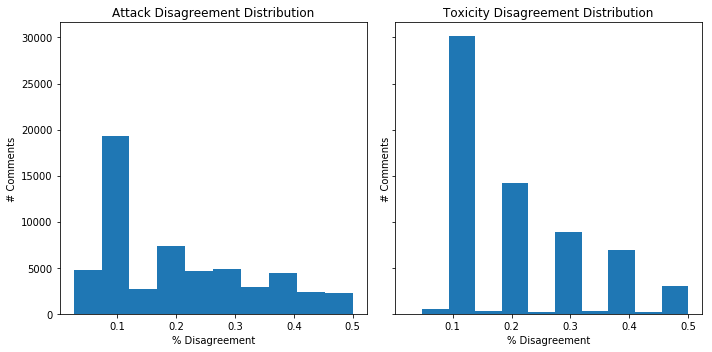

In [100]:
import matplotlib.pyplot as plt 
def set_plot_disagreement(df, i, title):
    axes[i].hist(df["percent_disagree"])
    axes[i].set_title(title)
    axes[i].set_xlabel("% Disagreement")
    axes[i].set_ylabel("# Comments")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True, sharey=True)
set_plot_disagreement(attack_disagreement, 0, "Attack Disagreement Distribution")
set_plot_disagreement(toxicity_disagreement, 1, "Toxicity Disagreement Distribution")
plt.savefig("images/DisagreementDistributions.png")
fig.tight_layout()

Comparing the distributions, it appears the level of disagreement is similar but distinctly different. Since the distributions as not normal, the Wilcoxon T test will be used to confirm if the disagreement is the same. The null hypothesis is that the sample distributions are equal. 

In [94]:
from scipy.stats import wilcoxon
stat, p = wilcoxon(toxicity[:10000], attack[:10000])
print('Statistics=%.3f, p=%.3f' % (stat, p)) #same distribution, fail to reject null hypothesis 

Statistics=17689656.000, p=0.001


Since the p-value < 0.05 the distributions for disagreement are not the same between the attack and toxicity datasets. This means the level of disagreement between the attack and toxicity datasets are different. This makes sense because people are biased by nature. Even when providing examples and a shared definition, the labellers were not consistent in their labelling such that for each comment there was always at least one labeller who disagreed with the rest of the labellers. Additionally, this analysis shows that labellers can have different levels of disagreement depending on the subject. In the case, the comparison was for comments containing personal attacks and toxicity. Lastly, a 20% disagreement average is fairly high which is why at least 10 labellers were required per comment. In addition to the recommendations from analysis one on demographics, more training could reduce bias. 

In [ ]:
## Step 2: Discuss further implications

The following discussion questions and responses are based on the knowledge gained from the analyses above and the demo applications in the gallery for ["Perspective Hacks"](https://github.com/conversationai/perspectiveapi/wiki/perspective-hacks).

### Discussion question 1

Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?

### Discussion question 2
Which, if any, of these demo applications would you expect the Perspective API to perform poorly in? Why?

### Discussion question 3
Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?